In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
tf.random.set_seed(1234)

keras = tf.keras

from numpy.random import seed
seed(1)
from pandas import DataFrame

dtypes = {'IsCanceled':'float64',}

#데이터를 받아서 그려주는 함수 
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

def trend(time, slope=0):
    return slope * time
  
  
def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

  
def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)
  
  
def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level
  

def seq2seq_window_dataset(series, window_size, batch_size=32,
                           shuffle_buffer=1000):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)
  

def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

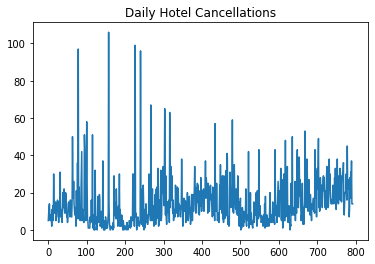

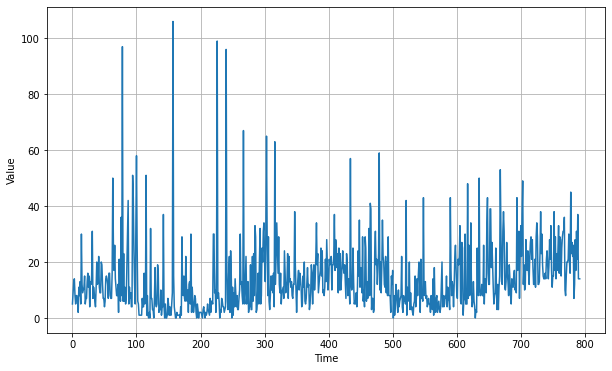

In [2]:
df = pd.read_csv("daily cancellations h1.csv", dtype=dtypes)
series = df['IsCanceled']
series=np.array(series)
plt.plot(series)
plt.title("Daily Hotel Cancellations")
plt.show()
time = np.arange(0, 793)
plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [3]:
#Train과 Valid데이터셋트 가르기 
split_time = 634
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [4]:
#1D-Conv Layer로 전처리 하기 
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 64
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size,
                                   batch_size=128)


In [5]:
#모델만들기

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
      keras.layers.Conv1D(filters=32,
                          kernel_size=5,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))
keras.layers.LSTM(32, return_sequences=True)
#keras.layers.Dense(1)
keras.layers.Dense(1, kernel_regularizer=keras.regularizers.l2(0.001))
keras.layers.Lambda(lambda x: x * 200)

optimizer = keras.optimizers.Adam(lr=3e-4)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h6", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)
history = model.fit(train_set, epochs=500,
                    validation_data=valid_set,
                    callbacks=[early_stopping, model_checkpoint])

Epoch 1/500


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


      5/Unknown - 4s 138ms/step - loss: 11.9333 - mae: 12.4228INFO:tensorflow:Assets written to: my_checkpoint.h6/assets
5/5 [==============================] - 9s 1s/step - loss: 11.9333 - mae: 12.4228 - val_loss: 18.9723 - val_mae: 19.4723
Epoch 2/500
5/5 [==============================] - 3s 776ms/step - loss: 11.5415 - mae: 12.0290 - val_loss: 18.1927 - val_mae: 18.6927
Epoch 3/500
5/5 [==============================] - 4s 863ms/step - loss: 10.9384 - mae: 11.4231 - val_loss: 16.8118 - val_mae: 17.3117
Epoch 4/500
5/5 [==============================] - 3s 760ms/step - loss: 10.1545 - mae: 10.6385 - val_loss: 14.5911 - val_mae: 15.0886
Epoch 5/500
5/5 [==============================] - 3s 764ms/step - loss: 9.4537 - mae: 9.9370 - val_loss: 12.1132 - val_mae: 12.6049
Epoch 6/500
5/5 [==============================] - 4s 895ms/step - loss: 9.2536 - mae: 9.7395 - val_loss: 11.0991 - val_mae: 11.5896
Epoch 7/500
5/5 [==============================] - 3s 785ms/step - loss: 9.1689 - mae: 9

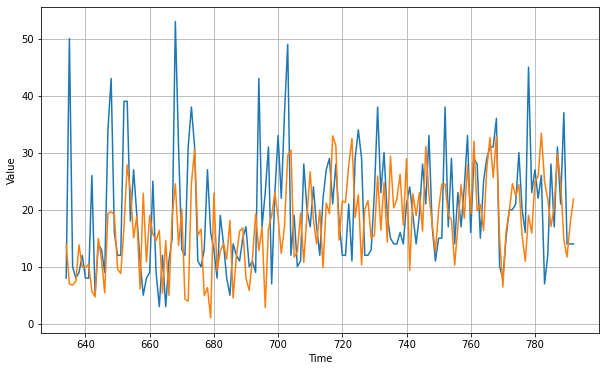

In [6]:
cnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
cnn_forecast = cnn_forecast[split_time - window_size:-1, -1, 0]
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, cnn_forecast)